In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

In [2]:
dtp = 7  # prediction length
path_to_directory = str(dtp)+"-day"
date_today = pd.to_datetime("today").strftime("%Y-%m-%d")
latest_folder = None  # find_latest_folder(path_to_directory)

result_dir = '.'+os.sep+'results'+os.sep+path_to_directory+os.sep
try:
    if not os.path.exists(result_dir):
        os.makedirs(result_dir)
except OSError:
    print("Error: Failed to create the directory.")
# current working dir is G:\My Drive\code_projects\btc_forecast which is why we need to specify the full path
base_dir = 'C:'+os.sep+'Users'+os.sep+'gjnet'+os.sep+'code_projects'+os.sep+'btc_forecast'

In [3]:
df = pd.read_csv('datasets/Bitstamp_BTCUSD_d.csv', skiprows=1, parse_dates=["date"])
df = df.sort_values('date').drop(columns=["unix"]).reset_index(drop=True)
df = df[df["date"] < pd.Timestamp("now").normalize()]  # Drop today's data as this is most likely incomplete
df.tail(2)

,date,symbol,open,high,low,close,Volume BTC,Volume USD
3753,2025-03-08,BTC/USD,86754.0,86861.0,85190.0,86192.0,579.749111,4.996974e+07
3754,2025-03-09,BTC/USD,86204.0,86469.0,80000.0,80708.0,1710.179388,1.380252e+08


In [4]:
df.dtypes, df.shape

(date          datetime64[ns]
 symbol                object
 open                 float64
 high                 float64
 low                  float64
 close                float64
 Volume BTC           float64
 Volume USD           float64
 dtype: object,
 (3755, 8))

In [5]:
ml_df = TimeSeriesDataFrame.from_data_frame(
    df,  # [df["date"]> '2022-11-08'],  # selecting data from last bull run - not a good idea (makes the model too optimistic)
    id_column="symbol",
    timestamp_column="date"
)
train_data = ml_df
# train_data, test_data = ml_df.train_test_split(prediction_length=dtp)
# print(train_data.shape, test_data.shape)

In [6]:
train_data.tail(2)

open     high      low    close   Volume BTC  \
item_id timestamp                                                     
BTC/USD 2025-03-08  86754.0  86861.0  85190.0  86192.0   579.749111   
        2025-03-09  86204.0  86469.0  80000.0  80708.0  1710.179388   

                      Volume USD  
item_id timestamp                 
BTC/USD 2025-03-08  4.996974e+07  
        2025-03-09  1.380252e+08

In [7]:
# test_data.tail(2)

Validation data size: 563
Rolling-window count: 80
Val step size: 40


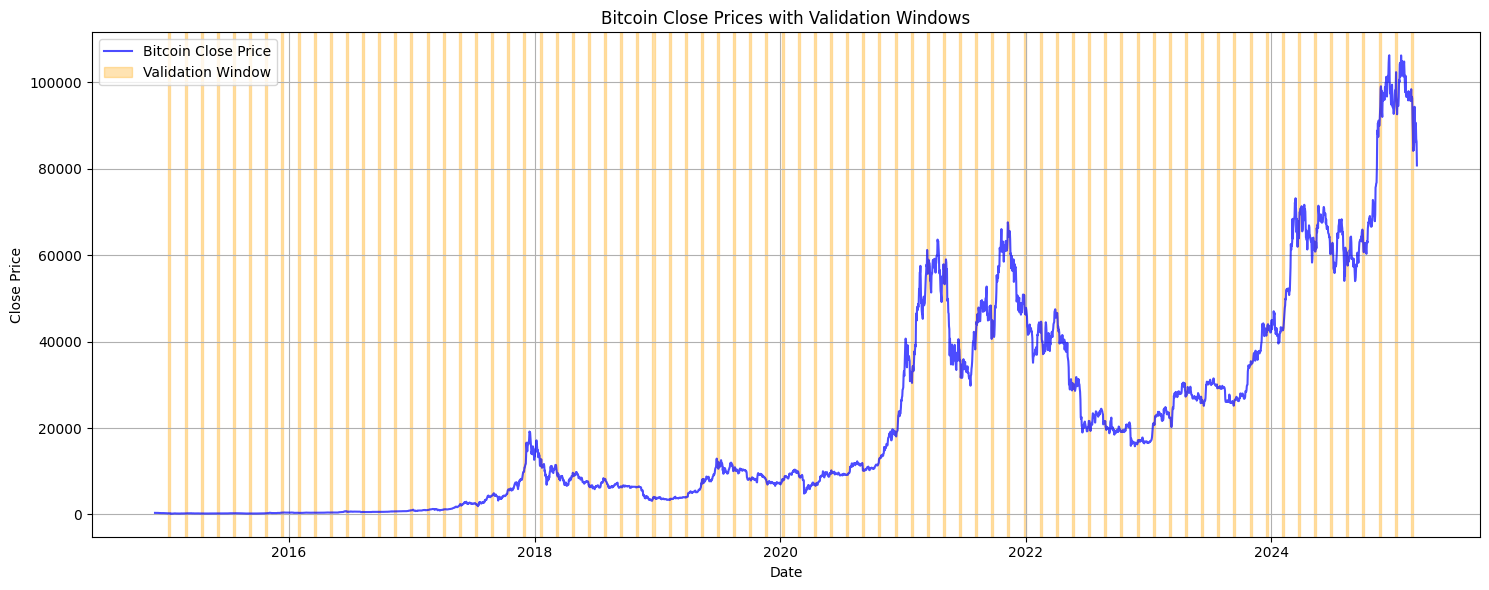

In [8]:
train_data_size = len(train_data)

val_size = int(train_data_size*0.15)  # % of validation data
print("Validation data size:", val_size)

n_windows = (val_size//dtp)
print("Rolling-window count:", n_windows)

val_step_size_n = (train_data_size - val_size) // (n_windows - 1)
print("Val step size:", val_step_size_n)

viz_df = train_data.reset_index().set_index("timestamp")

# Ensure the windows span the entire dataset, including at the end
validation_windows = []
current_iloc = 0
for i in range(n_windows):
    start_idx = current_iloc + val_step_size_n
    end_idx = start_idx + dtp
    if end_idx <= len(viz_df):  # Ensure indices are within bounds
        validation_windows.append((start_idx, end_idx))
    current_iloc = end_idx + 1

# Plot the Bitcoin close prices
plt.figure(figsize=(15, 6))
plt.plot(viz_df.index, viz_df["close"], label="Bitcoin Close Price", color="blue", alpha=0.7)

# Highlight validation windows
for start_idx, end_idx in validation_windows:
    plt.axvspan(viz_df.index[start_idx], viz_df.index[end_idx - 1],
                color="orange", alpha=0.3,
                label="Validation Window" if start_idx == validation_windows[0][0] else None)

# Add labels and legend
plt.title("Bitcoin Close Prices with Validation Windows")  # with n-fold: "+str(z))
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid()
plt.tight_layout()

try:
    plt.savefig(result_dir+date_today+'_val_windows.png')
except Exception as e:
    print(e)
    pass

plt.show()

In [10]:
# Get today's date
today = pd.to_datetime("today")
max_date = df["date"].max()+pd.Timedelta(days=dtp)
error_metric = "RMSE"
max_train_dur = 12*(60*60)  # seconds = hours*(min*sec)

# Check if the given date is older or equal to today's date
if (max_date >= today) and (latest_folder is not None):
    print("Using existing model")
    predictor = TimeSeriesPredictor.load(path_to_directory+os.sep+latest_folder)
else:
    print("Training a new model, this will take up to "+str(max_train_dur//60//60)+" hours")
    predictor = TimeSeriesPredictor(
        prediction_length=dtp,
        target="close",
        eval_metric=error_metric,
        path=base_dir+os.sep+path_to_directory
    )

    predictor.fit(
        train_data,
        presets="best_quality",  # 'fast_training'
        time_limit=max_train_dur,
        num_val_windows=n_windows,        # Rolling validation windows
        val_step_size=val_step_size_n,  # Controlling overlapping between validation windows, len(train_data)//n_windows means this:
        #|-------------------|
        #| x x x x x y y - - |
        #          | x x x x x x y y - |
        #                      | x x x x x x x y y |
        # val_step_size=1 (default) means this (and set num_val_windows to something very high e.g. 1/3 of dataset):
        #|-------------------|
        #| x x x x x y y - - |
        #| x x x x x x y y - |
        #| x x x x x x x y y |
        refit_full=True,
        hyperparameters={
            "PatchTST": {},
            "TiDE": {},
            "TemporalFusionTransformer": {},
            # "DynamicOptimizedTheta": {},
            # "DeepAR": {},
        }
        # excluded_model_types = excluded_model_types
    )

Beginning AutoGluon training... Time limit = 43200s
AutoGluon will save models to 'C:\Users\gjnet\code_projects\btc_forecast\7-day'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.8
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          16
GPU Count:          0
Memory Avail:       10.31 GB / 31.29 GB (32.9%)
Disk Space Avail:   541.20 GB / 930.76 GB (58.1%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'hyperparameters': {'DynamicOptimizedTheta': {},
                     'PatchTST': {},
                     'TemporalFusionTransformer': {},
                     'TiDE': {}},
 'known_covariates_names': [],
 'num_val_windows': 80,
 'prediction_length': 7,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': True,
 'skip_model_selection': False,
 'targ

Training a new model, this will take up to 12 hours


	-1245.2757    = Validation score (-RMSE)
	388.86  s     = Training runtime
	1.34    s     = Validation (prediction) runtime
Training timeseries model TemporalFusionTransformer. Training for up to 14069.9s of the 42809.7s of remaining time.
	Time limit adjusted due to model hyperparameters: 177.16s -> 159.44s (ag.max_time_limit=None, ag.max_time_limit_ratio=0.9, ag.min_time_limit=0)
	Time limit adjusted due to model hyperparameters: 178.62s -> 160.76s (ag.max_time_limit=None, ag.max_time_limit_ratio=0.9, ag.min_time_limit=0)
	Time limit adjusted due to model hyperparameters: 179.79s -> 161.81s (ag.max_time_limit=None, ag.max_time_limit_ratio=0.9, ag.min_time_limit=0)
	Time limit adjusted due to model hyperparameters: 181.14s -> 163.03s (ag.max_time_limit=None, ag.max_time_limit_ratio=0.9, ag.min_time_limit=0)
	Time limit adjusted due to model hyperparameters: 182.57s -> 164.31s (ag.max_time_limit=None, ag.max_time_limit_ratio=0.9, ag.min_time_limit=0)
	Time limit adjusted due to model 

In [11]:
# The test score is computed using the last dts of each time series in test_data
leaderboard_df = predictor.leaderboard(train_data).sort_values(["score_val"], ascending=False)  # test_data
error_val = leaderboard_df["score_val"].max()

try:
    leaderboard_df.to_csv(result_dir+date_today+'_leaderboard.csv')
except Exception as e:
    print(e)
    pass

display(leaderboard_df)
# leaderboard_df.loc[leaderboard_df[["score_test", "score_val"]].mean(axis=1).sort_values().index[-1]]

all_hyperparams = {}

# Iterate over all rows in the leaderboard
for model_name in leaderboard_df["model"]:
    # Load the model object from predictor._trainer
    model_obj = predictor._trainer.load_model(model_name)

    # Extract hyperparameters (for many models, this is stored in .params)
    hyperparams = model_obj.params

    # Store them in a dictionary keyed by model name
    all_hyperparams[model_name] = hyperparams

# Now all_hyperparams is a dict of model_name -> hyperparam dict
print(all_hyperparams)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
3,WeightedEnsemble,-3018.440892,-843.210824,0.108524,0.050241,16.341201,5
5,PatchTST,-3420.983956,-887.328541,0.024555,0.011986,2953.330963,3
1,TiDE,-2998.075296,-908.166485,0.030342,0.017637,6628.703900,4
7,TemporalFusionTransformer,-4459.171938,-944.618774,0.051627,0.020618,6960.563471,2
9,DynamicOptimizedTheta,-8093.110017,-1245.275703,44.037249,1.340042,388.862243,1
0,TiDE_FULL,-2998.075296,NaN,0.025152,NaN,81.613905,9
2,WeightedEnsemble_FULL,-3018.440892,NaN,0.106099,NaN,16.341201,10
4,PatchTST_FULL,-3420.983956,NaN,0.026407,NaN,25.381499,8
6,TemporalFusionTransformer_FULL,-4459.171938,NaN,0.053087,NaN,70.781500,7
8,DynamicOptimizedTheta_FULL,-8093.110017,NaN,46.811419,NaN,0.004019,6


{'WeightedEnsemble': {}, 'PatchTST': {}, 'TiDE': {}, 'TemporalFusionTransformer': {}, 'DynamicOptimizedTheta': {}, 'TiDE_FULL': {}, 'WeightedEnsemble_FULL': {}, 'PatchTST_FULL': {}, 'TemporalFusionTransformer_FULL': {}, 'DynamicOptimizedTheta_FULL': {}}


Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble_FULL


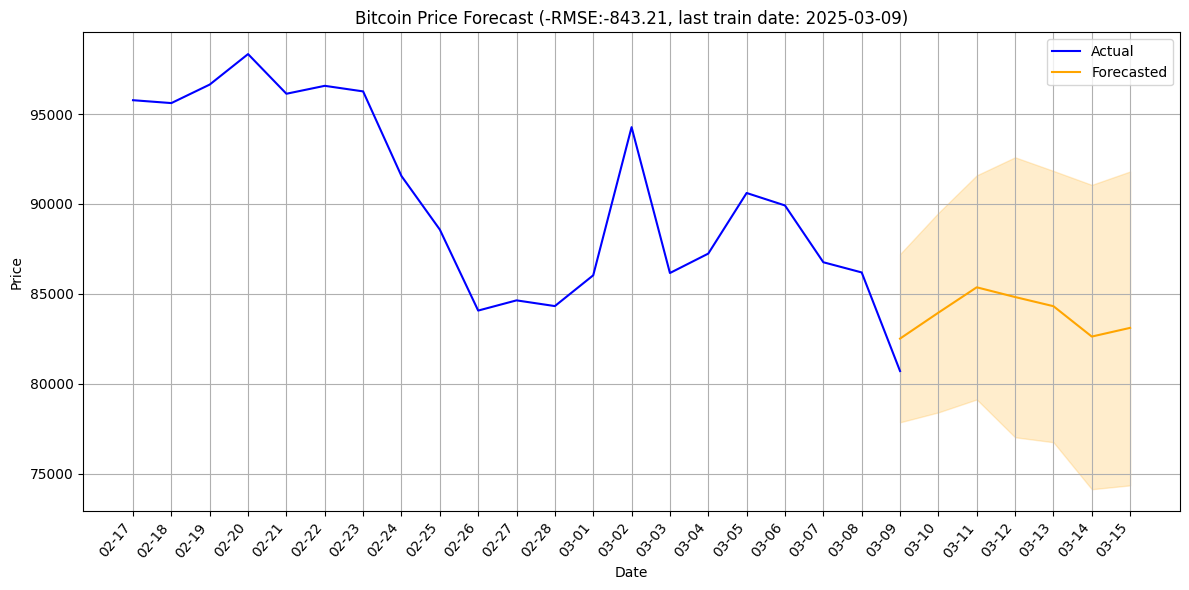

In [12]:
# Split the data points in half
viz_dp = dtp * 3

# Last train date
last_train_date = df["date"].max().strftime("%Y-%m-%d")

# Label config
x_lbl_bins = 20
x_lbl_rot = 50

# # predictions = predictor.predict(train_data)  # , model=model_to_use)
# # predictions.tail(2)

forecasts = predictor.predict(train_data.iloc[:-1])  # , model=model_to_use)
# # forecasts.head()

# # Reset the index to access 'timestamp' as a column
train_data_reset = train_data.reset_index().iloc[-viz_dp:]
# test_data_reset = test_data.reset_index().iloc[-viz_dp:]
# predictions_reset = predictions.reset_index().iloc[-viz_dp:]
forecasts_reset = forecasts.reset_index().iloc[-viz_dp:]

# Create a figure with 2 subplots (1 row, 2 columns)
# fig, axes = plt.subplots(1, 1, figsize=(12, 6))

# Format the dates to display only month and day
train_data_reset['timestamp'] = train_data_reset['timestamp'].dt.strftime('%m-%d')
# test_data_reset['timestamp'] = test_data_reset['timestamp'].dt.strftime('%m-%d')
# predictions_reset['timestamp'] = predictions_reset['timestamp'].dt.strftime('%m-%d')
forecasts_reset['timestamp'] = forecasts_reset['timestamp'].dt.strftime('%m-%d')

# Create a single figure
plt.figure(figsize=(12, 6))  # Create a single figure

# Plot actual and forecasted data together
plt.plot(train_data_reset['timestamp'], train_data_reset['close'], label='Actual', color='blue')
plt.plot(forecasts_reset['timestamp'], forecasts_reset['mean'], label='Forecasted', color='orange')
plt.fill_between(forecasts_reset['timestamp'], forecasts_reset['0.1'], forecasts_reset['0.9'], color='orange', alpha=0.2)

plt.title('Bitcoin Price Forecast (-'+error_metric+':'+str(round(error_val, 2))+', last train date: '+last_train_date+')')  # Add a clear title
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

# Rotate x-axis labels if needed
plt.xticks(rotation=x_lbl_rot, ha='right')

plt.tight_layout()

try:
    plt.savefig(result_dir+date_today+'_forecasts.png')
except Exception as e:
    print(e)
    pass

plt.show()